### Latent ideology of users

LI is based on the media outlet shared by each user, therefore the ideology reflects the group of media an user shares.

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(123459)

In [159]:
# Data with only columns of interest
data = pd.read_csv('Data/dataEchoChambers.csv', usecols=['tw_id', 'fecha', 'usr_id', 'opinion_dinamic', 'url_expanded', 'medio'])
data['fecha'] = pd.to_datetime(data['fecha'])
data.head(n = 5)

,fecha,url_expanded,medio,opinion_dinamic,tw_id,usr_id
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346910135377920,716295311342321665
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346845589233665,271519704
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350580142903296,987494618156675072
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350441126936580,770375532
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101353444135370754,740350122974937088


### Encoding matrix user - media share
User - media shares dataframe based on one-hot encoding of media shares

In [160]:
user_media_df = pd.DataFrame()

# user_id column
user_media_df['usr_id'] = data['usr_id']

#creating instance of one-hot-encoder and one-hot encoding of media shares
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['medio']]).toarray())
encoder_df.columns = list(encoder.categories_[0])

user_media_df = user_media_df.join(encoder_df)

In [161]:
user_media_df = user_media_df.groupby('usr_id').sum()
user_media_df.head(n = 5)

,Ambito Financiero,Clarin,Contexto,Diario Registrado,El Cronista,El Destape,El Dia,El Litoral,Infobae,Jornada,La Izquierda Diario,La Nacion,Minuto Uno,Pagina 12,Perfil,Radio Dos,Radio Mitre,TYC Sports,Todo Noticias
usr_id,,,,,,,,,,,,,,,,,,,
12864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59173,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
624143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
760916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
ppal_media = ['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']
ppal_media += ['Ambito Financiero', 'Minuto Uno', 'Perfil']#, 'El Cronista', 'El Dia', 'Radio Mitre']

user_media_df_filtrado = user_media_df[ppal_media].copy()
user_media_df_filtrado = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 0].copy()

In [163]:
# Matrix of user - media shared
A = user_media_df_filtrado.to_numpy()

In [164]:
score_users = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users = (score_users - np.mean(score_users))/np.std(score_users)

for iteration in range(50):
    
    score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
    score_users = np.array([np.average(score_media, weights=A[j,:]) for j in range(A.shape[0])])

    score_users = (score_users - np.mean(score_users))/np.std(score_users)

In [165]:
score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
media_score = [[user_media_df_filtrado.columns[i], score_media[i]] for i in range(len(score_media))]
print(media_score)

[['Clarin', 0.6171500192242491], ['La Nacion', 0.5387209785488476], ['Pagina 12', -1.3505449679679564], ['Todo Noticias', 0.6450424720044629], ['Infobae', 0.4063126979345714], ['El Destape', -1.4793805540008484], ['Ambito Financiero', -0.5670142210838602], ['Minuto Uno', -1.2818029071750234], ['Perfil', -0.04571567854247023]]


[-1.72142282  0.8602347 ]


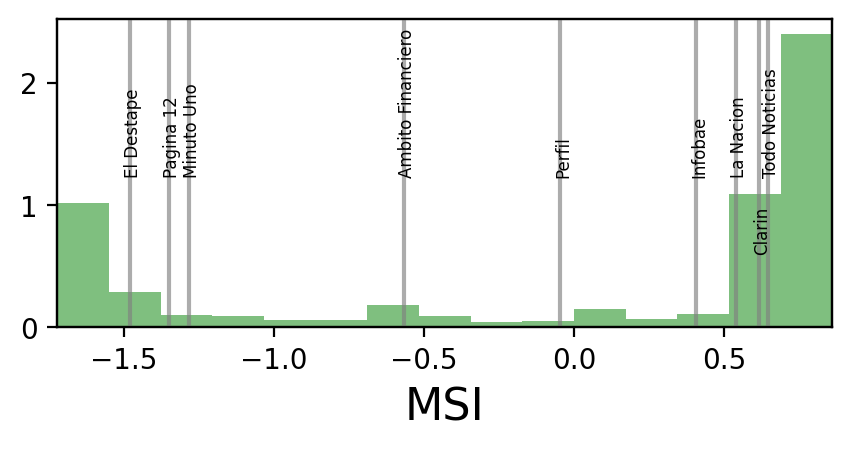

In [166]:
# Scores of the users
fig, ax = plt.subplots(dpi = 200, figsize=(5,2))
ax.hist(score_users, bins = 15, alpha = 0.50, color = 'g', density = True)
ax.set_xlabel(r'MSI', size = 16)

ax2 = ax.twinx()
for ms in media_score:
    ax2.axvline(ms[1], color = 'grey', alpha = 0.65)
    if ms[0] != 'Clarin':
        ax2.text(x = ms[1]-0.02, y = 0.5, s=ms[0], rotation = 90, size = 6)
    else: 
        ax2.text(x = ms[1]-0.02, y = 0.25, s=ms[0], rotation = 90, size = 6)
ax2.set_yticks([])
ax.set_xlim(np.quantile(score_users, q = [0.005, 0.995]))
print(np.quantile(score_users, q = [0.005, 0.995]))
plt.show()

In [167]:
user_media_df_filtrado['score'] = score_users

### MSI of media as a function of time

In [168]:
media_score_month = []

for month in range(3, 11):
    
    data_month = data[data.fecha.apply(lambda x: x.month) == month].copy()

    user_media_df = pd.DataFrame()

    # user_id column
    user_media_df['usr_id'] = data_month['usr_id']

    #creating instance of one-hot-encoder and one-hot encoding of media shares
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(data[['medio']]).toarray())
    encoder_df.columns = list(encoder.categories_[0])

    user_media_df = user_media_df.join(encoder_df)

    user_media_df = user_media_df.groupby('usr_id').sum()

    user_media_df_filtrado = user_media_df[ppal_media].copy()
    user_media_df_filtrado = user_media_df_filtrado[user_media_df_filtrado.apply(np.count_nonzero, axis = 1) > 0].copy()

    # Matrix of user - media shared
    A = user_media_df_filtrado.to_numpy()

    score_users = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
    score_users = (score_users - np.mean(score_users))/np.std(score_users)

    for iteration in range(50):
    
        score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
        score_users = np.array([np.average(score_media, weights=A[j,:]) for j in range(A.shape[0])])

        score_users = (score_users - np.mean(score_users))/np.std(score_users)

    score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])

    # Clarin have index positive
    if score_media[0] < 0:
        score_media = -score_media
    media_score_month.append(score_media)    

In [169]:
media_score_month = np.array(media_score_month)

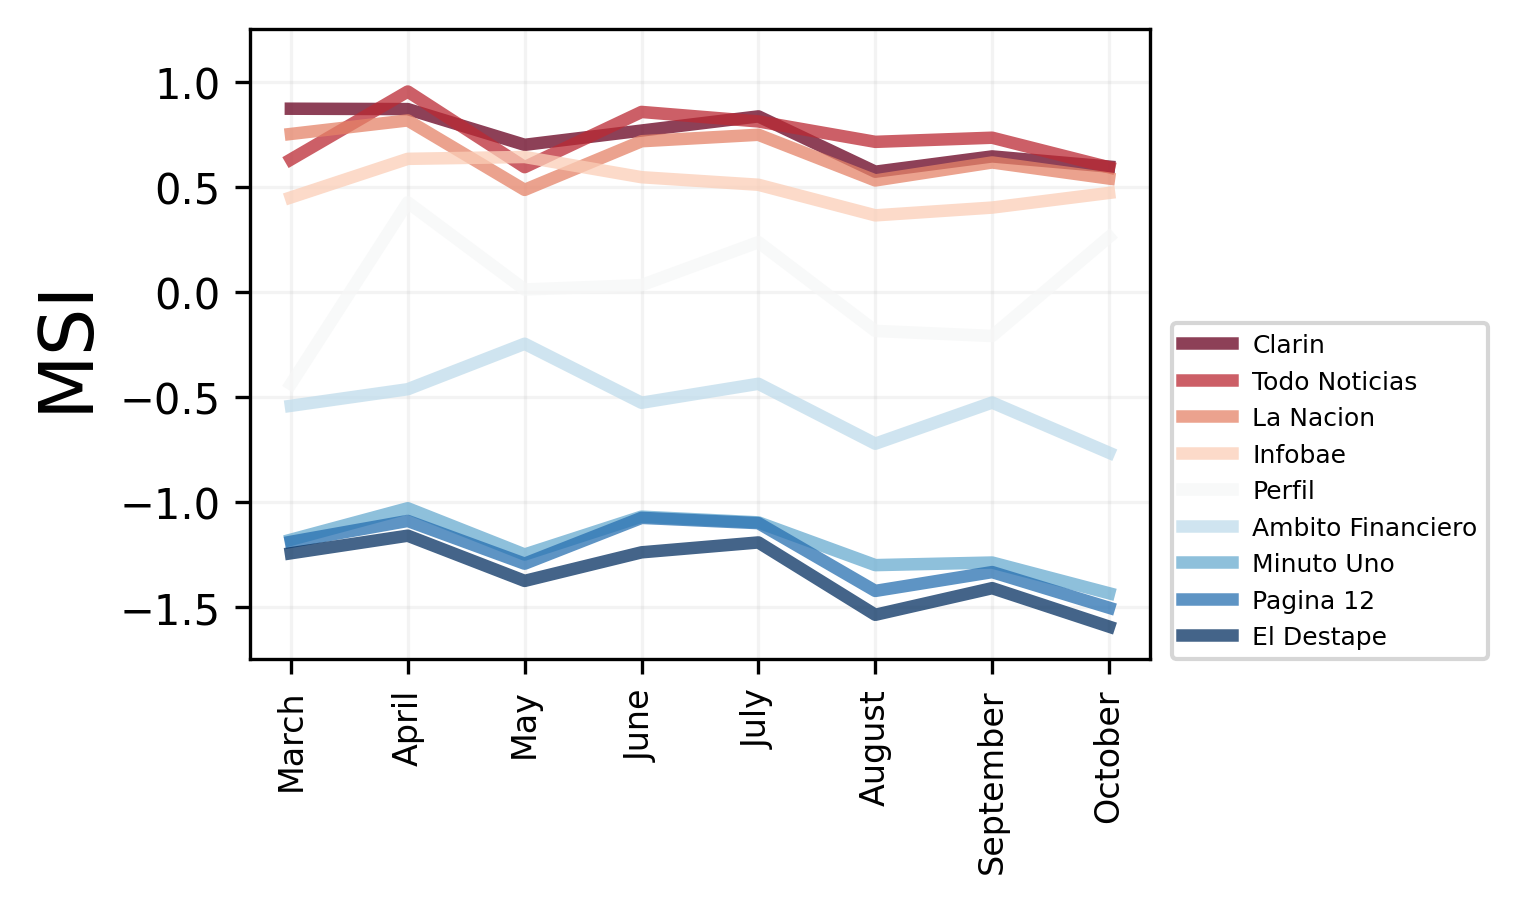

In [185]:
plt.figure(dpi = 300, figsize = (5,3))
plt.axes([0.15, 0.25, 0.60, 0.70])
colors = plt.get_cmap('RdBu')(np.linspace(0.00, 1.00, len(ppal_media)))
j = 0
for i in sorted(range(len(ppal_media)), reverse = True, key = lambda x: media_score_month[-1,x]):
    plt.plot(range(3, 11), media_score_month[:,i], linestyle = '-', label = ppal_media[i], 
             color = colors[j], 
             linewidth = 3, alpha = 0.75)
    j += 1
plt.legend(loc = [1.025, 0.00], fontsize = 6)
plt.ylim([-1.75, 1.25])
plt.xticks(range(3, 11), ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'], rotation = 90, fontsize = 8)
plt.ylabel('MSI', size = 18)
plt.grid(True, alpha = 0.15)
plt.savefig('Results/MSI_time.png')
plt.show()